In [4]:
import numpy as np
import cv2 as cv
from PIL import Image
from src import load_img, select_points
import matplotlib.pyplot as plt

In [ ]:
img = load_img('./data/CALIB_ALEX_VEIKKA.png')
points = select_points(img)

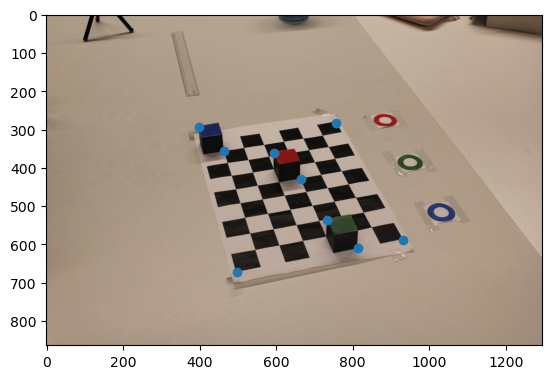

In [9]:
pts = points.copy()
pts[:, 1] = img.size[1] - pts[:, 1] - 1
plt.imshow(img)
plt.scatter(*zip(*pts))